In [233]:
import pandas as pd
from pprint import pprint
import requests
import json
import ast
import matplotlib.pyplot as plt
low_memory=False

In [4]:
# Read csv file 
csv_file = 'Resources/recentMovieTitles.csv'
movie_titles = pd.read_csv(csv_file)

In [5]:
movie_titles['genres'].value_counts()

Documentary               52592
Drama                     36345
Comedy                    15161
\N                        12148
Horror                     6481
                          ...  
Music,Mystery                 1
Musical,Reality-TV            1
Adventure,War                 1
Biography,Comedy,Sport        1
Comedy,Sci-Fi,Sport           1
Name: genres, Length: 1149, dtype: int64

In [ ]:
# Get The Movie Database IDs For Each Movie
movie_ids = []
totalNumMovies = len(movie_titles)
setRequestCounter = 1
readCurrentIndexFile = open("Resources/currentIndex.txt", "r")
requestIndexCounter = int(readCurrentIndexFile.read())
foundCounter = 0
notFoundCounter = 0

while requestIndexCounter <= totalNumMovies:
    if setRequestCounter <= 500:
        if setRequestCounter == 100:
            print("SET: 100/500")
        elif setRequestCounter == 200:
            print("SET: 200/500")
        elif setRequestCounter == 300:
            print("SET: 300/500")
        elif setRequestCounter == 400:
            print("SET: 400/500")
        title = movie_titles['primaryTitle'].iloc[requestIndexCounter]
        year = movie_titles['startYear'].iloc[requestIndexCounter]
        url = f"https://api.themoviedb.org/3/search/movie?api_key=c1c6e406a72fd9e2c34c45bf23702c82&query={title}&year={year}"
        request = requests.get(url)
        requestJSON = request.json()
        #print(request)
        if request.status_code == 200:
            if requestJSON['total_results'] != 0:
                movie_ids.append(requestJSON['results'][0]['id'])
                foundCounter += 1
                #print(f"FOUND: {title}! | SET: {setRequestCounter}/500 | TOTAL: {requestIndexCounter}/{totalNumMovies}")
            else:
                notFoundCounter += 1
                #print(f"NOT FOUND: {title}. Trying next movie.. | SET: {setRequestCounter}/500 | TOTAL: {requestIndexCounter}/{totalNumMovies}")            

        requestIndexCounter += 1
        setRequestCounter += 1
    else:
        movie_ids_df = pd.DataFrame(movie_ids)
        movie_ids_df.to_csv('Resources/TMDBMovieIDS.csv', mode='a', header=False, index=False)
        writeCurrentIndexFile = open("Resources/currentIndex.txt", "w")
        writeCurrentIndexFile.write(str(requestIndexCounter))
        writeCurrentIndexFile.close()
        setRequestCounter = 1
        movie_ids = []
        foundCounter = 0
        notFoundCounter = 0
        print(f"""--- SAVING PROGRESS TO CSV ---
        SET: {setRequestCounter-1}/500 | TOTAL: {requestIndexCounter}/{totalNumMovies}
        Found: {foundCounter}
        Not Found: {notFoundCounter}
        % Found: {round(foundCounter/(foundCounter+notFoundCounter)*100,2)}""")


#PROCESS COMPLETE                                                                              
print('''---------------------------
DATA RETRIEVAL PROCESS COMPLETE!
---------------------------''')

SET: 100/500
SET: 200/500
SET: 300/500
SET: 400/500


In [2]:
movie_json_file = 'Resources/TMDBMovieJSON.csv'
movie_json = pd.read_csv(movie_json_file,lineterminator='\n')
movie_json_df = pd.DataFrame(movie_json)
movie_clean_df = movie_json_df.loc[movie_json_df['revenue']!=0,:]

In [3]:
print(len(movie_clean_df))
print(len(movie_json_df))

5910
66111


In [4]:
movie_recent_clean_df = movie_clean_df.loc[pd.to_numeric(movie_clean_df['release_date'].str[:4]) >= 2000,:]

In [5]:
movie_recent_clean_df['release_date'].str[:4].value_counts()

2014    616
2013    605
2015    539
2012    533
2016    523
2011    468
2010    466
2017    407
2009    369
2008    214
2018    188
2007    115
2019    107
2006     78
2005     71
2003     52
2004     47
2002     44
2001     33
2000     26
2020      4
Name: release_date, dtype: int64

In [8]:
movie_recent_clean_df.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'credits'],
      dtype='object')

In [32]:
movie_recent_clean_df['genres'].value_counts().head()

[{'id': 18, 'name': 'Drama'}]                                       531
[{'id': 35, 'name': 'Comedy'}]                                      321
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]     191
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]         159
[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]    154
Name: genres, dtype: int64

In [205]:
genre_movie_df = movie_recent_clean_df.loc[:,['id','imdb_id','budget','runtime','original_title','title','revenue','release_date','genres']]

In [177]:
len(genre_movie_df)

5505

In [212]:
for i, genre in genre_movie_df.iterrows():
    cur_row = genre_movie_df.loc[i, "genres"]
    row_json = ast.literal_eval(cur_row)
    
    try:
        new_genre = row_json[0]['name']
    except IndexError:
        new_genre = 'NA'
    
    genre_movie_df.set_value(i, 'genre', new_genre)

/Users/kevinscheller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [242]:
genre_movie_df.to_csv('Resources/GenreMovies.csv')

In [ ]:
# --- START HERE BY USING GENREMOVIES FILE ---

In [243]:
csv_file = 'Resources/GenreMovies.csv'
genre_movie_df = pd.read_csv(csv_file)

In [244]:
genre_movie_grouping_df = genre_movie_df.loc[:,['genre','budget','revenue']].groupby('genre').mean().astype(int)

In [245]:
genre_movie_grouping_df

,budget,revenue
genre,,
Action,51798983,165433400
Adventure,84388243,269372290
Animation,48861692,203004753
Comedy,16270915,51570190
Crime,20422056,51184627
Documentary,1018284,3658850
Drama,12183681,38059328
Family,38927486,152352281
Fantasy,47625225,153805006


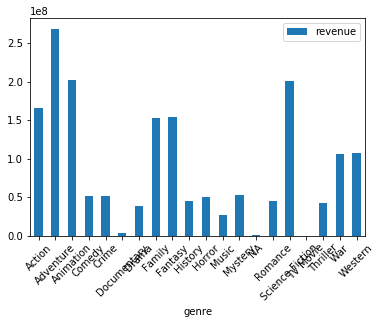

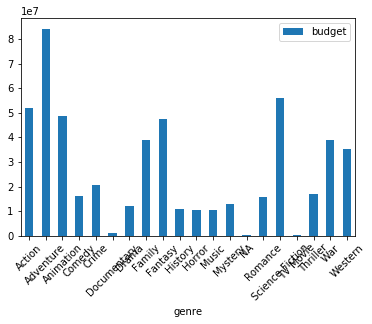

In [241]:
p1 = genre_movie_grouping_df.reset_index().plot.bar(x='genre', y='revenue', rot=45)
p2 = genre_movie_grouping_df.reset_index().plot.bar(x='genre', y='budget', rot=45)
plt.show()